## Microsoft Object Detection Explainability (D-RISE) Tutorial

Authors: Raphi Kang, Shreya Ravikumar. 2023 internship at Microsoft Explainable AI Team, with Ilya Matiach, Jimmy Hall

This tutorial will walk us through the process of fine-tuning a pretrained object detection model, then generating saliency maps with the [D-RISE (Detector Randomized Input Sampling for Explanation)](https://arxiv.org/abs/2006.03204) method. The same results can also be achieved by using our python package [EXPLAINABILITY PACKAGE](https://link).
D-RISE is a black-boxed, or model-agnostic, explainability method which can produce saliency maps for any object detection or instance segmentation models provided these models are appropriately wrapped. In essence, D-RISE works by random masking the input images and isolating the parts that are most pertinent for the detection or segmentation of the object in question. In this implementation, we ________.

First we install all necessary dependencies and import them.

In [ ]:
!pip install captum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.9 MB/s eta 0:00:00


In [ ]:
!pip install BeautifulSoup4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


We will also install the EXPLAINABILITYPACKAGE for access its dependencies.

In [ ]:
!pip install EXPLAINABILITYPACKAGE #package associated with tutorial

In [ ]:
import torch
import torch.utils.data
import torchvision
import torchvision.models.detection as detection
from torchvision import transforms as T
from torchvision.transforms import functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

import matplotlib.pyplot as plt
import PIL.Image as Image
import cv2
import os
import numpy 
import pandas as pd

from bs4 import BeautifulSoup
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from captum.attr import visualization as viz
#import argparse

# from EXPLAINABIITYPACKAGE import automlexp.automlexp.common.drise as drise      #--> these import statements should be replaced with package commands
# from EXPLAINABIITYPACKAGE import automlexp.automlexp.common.common as od_common

# 1. Fine-tuning an Object Detection Model

If you already have a pretrained model you would like to load, you can skip to the next portion. In this section, we will be showing how to finetune a Faster R-CNN or RetinaNet model on a recycling dataset. Many of the steps follow the TorchVision Object Detection Finetuning tutorial. (https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html. 

### Recyling finetuning - creating the dataset




First, let's download and extract the data from Microsoft computer-vision recipes.

In [ ]:
# download the Fridge objects dataset from Microsoft computer-vision recipes
!wget https://cvbp-secondary.z19.web.core.windows.net/datasets/object_detection/odFridgeObjects.zip .
# extract it in the current folder
!unzip odFridgeObjects.zip

Now let's write a custom dataset for the odFridgeObjects dataset with data augmentation. 

In [ ]:
#@title Data augmentation 
# Set train=True for training transforms and False for val/test transforms
def get_transform(train):
    if train:
        return A.Compose([A.HorizontalFlip(0.5),
                            A.VerticalFlip(p=0.2),
                            A.CropAndPad(percent = (0, 0.1)),
                            A.GaussianBlur(sigma_limit = 0.05, p = 0.5),
                            A.RandomBrightnessContrast(brightness_limit = 0.05, contrast_limit = 0.05, p = 0.5),
                            A.Affine(
                                    scale= {"x": (1, 1.5), "y": (1, 1.5)},
                                    translate_percent={"x": (0, 0.05), "y": (0, 0.05)},
                                    rotate=[-3, 3],
                            ),
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [ ]:
#@title Defining the Fridge Dataset class 
class FridgeDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images/"))))[2:]
        self.boxes = list(sorted(os.listdir(os.path.join(root, "annotations/"))))[2:]

    def __getitem__(self, idx):
        # load images 
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        box_path = os.path.join(self.root, "annotations", self.boxes[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # get bounding box coordinates and labels for each annotation
        with open(box_path, 'r') as f:
            data = f.read() 

        bs_data = BeautifulSoup(data, 'xml') 
        xmin = bs_data.find_all('xmin') 
        xmax = bs_data.find_all('xmax') 
        ymin = bs_data.find_all('ymin') 
        ymax = bs_data.find_all('ymax') 

        label = bs_data.find_all('name') 
        label_dict = {'can': 1, 'carton': 2, 'milk_bottle': 3, 'water_bottle': 4}

        boxes = []
        labels = []
        for i in range(0,len(xmin)):
            box = [int(xmin[i].get_text()),int(ymin[i].get_text()),
                    int(xmax[i].get_text()),int(ymax[i].get_text())]
            boxes.append(box)
            labels.append(label_dict[label[i].get_text()])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((len(label),), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        # apply transforms to 
        if self.transforms:
            transform = self.transforms(image = img,
                                    bboxes = target['boxes'],
                                    labels = target['labels'])
                
            img = transform['image']
            target['boxes'] = torch.Tensor(transform['bboxes'])
                
        img = F.convert_image_dtype(img, torch.float)
        return img, target

    def __len__(self):
        return len(self.imgs)

### Recyling finetuning - training the model


First, we need to install all the necessary dependencies and import them. 

In [ ]:
!pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'


There are helper functions to simplify training and evaluating object detection models in the references/detection/ subdirectory of TorchVision. Here, we will use references/detection/engine.py, references/detection/utils.py and references/detection/transforms.py.

Let's copy those files (and their dependencies) in here so that they are available in the notebook.

In [ ]:
# Download TorchVision repo to use some files from references/detection
!git clone https://github.com/pytorch/vision.git
!cd vision
!cp ./vision/references/detection/utils.py ../
!cp ./vision/references/detection/transforms.py ../
!cp ./vision/references/detection/coco_eval.py ../
!cp ./vision/references/detection/engine.py ../
!cp ./vision/references/detection/coco_utils.py ../

In [ ]:
from engine import train_one_epoch, evaluate
import utils

Then, we need to define the model. Here are examples of how to load the  Faster R-CNN and RetinaNet models.




In [ ]:
#@title Loading the model
def get_retinanet_model(num_classes):
    # load an object detection model pre-trained on COCO
    model = torchvision.models.detection.retinanet_resnet50_fpn_v2(weights='RetinaNet_ResNet50_FPN_V2_Weights.DEFAULT')
    # replace classification layer 
    in_channels = 256
    num_anchors = model.head.classification_head.num_anchors
    model.head.classification_head.num_classes = num_classes

    cls_logits = torch.nn.Conv2d(in_channels, num_anchors * num_classes, kernel_size = 3, stride=1, padding=1)
    torch.nn.init.normal_(cls_logits.weight, std=0.01)  # as per pytorch code
    torch.nn.init.constant_(cls_logits.bias, -math.log((1 - 0.01) / 0.01))  # as per pytorch code 
    model.head.classification_head.cls_logits = cls_logits

    return model
    
def get_fastercnn_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights ='FasterRCNN_ResNet50_FPN_Weights.DEFAULT')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

Finally, let's train and save our finetuned model. 

In [ ]:
#@title Training the model
def train_model():
    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # our dataset has two classes only - background and person
    num_classes = 5 
    # use our dataset and defined transformations
    dataset = FridgeDataset('odFridgeObjects', get_transform(train=True))
    dataset_test = FridgeDataset('odFridgeObjects', get_transform(train=False))

    # split the dataset in train and test set
    torch.manual_seed(1)
    indices = torch.randperm(len(dataset)).tolist()
    dataset = torch.utils.data.Subset(dataset, indices[:-20])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-20:])

    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=4,
        collate_fn=utils.collate_fn)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=4,
        collate_fn=utils.collate_fn)

    # get the model using our helper function
    model = get_fastercnn_model(num_classes)
    # model = get_retinanet_model(num_classes) # uncomment to use retinanet model

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

    # let's train it for 10 epochs
    num_epochs = 10

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)

    print("That's it!")
    torch.save(model.state_dict(), 'Recycling_finetuned_FastRCNN.pt')

In [ ]:
train_model()

# 2. Loading in your pre-trained model and test images

Next, we load in our pretrained model and visualize its detections on some test image through D-RISE. The specific D-RISE implementation is detailed in [PART OF THE PACKAGE WHERE THE IMPLEMENTATION IS] which we imported earlier.

In [ ]:
#Loading in our pretrained model      
def get_fastercnn_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model


num_classes = 5
model = get_fastercnn_model(num_classes)
model.load_state_dict(torch.load('Recycling_finetuned_FastRCNN.pt'))

#if using the general torchvision pretrained model, comment above and uncomment below
# model = detection.fasterrcnn_resnet50_fpn(pretrained=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

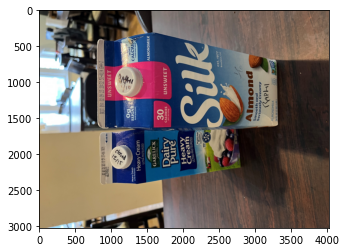

In [ ]:
#load in a test image
test_image = Image.open("cartons.jpg")
plt.imshow(test_image)

Without any additional wrapping, the output of this model looks like:

In [ ]:
model.eval()
detections = model(T.ToTensor()(test_image).unsqueeze(0))

This output format is model specific - other implementations of other models use different formats. To use DRISE, we need to standardize the output format.


# Setup DRISE Model Wrapper

DRISE expects a common model output format, which is a list of "Detection Records". The wrapper for Faster R-CNN and RetinaNet are written here - if your model is of a different type, you have to write a wrapper to match this output type before you continue.

In [ ]:
#@title Faster R-CNN/RetinaNet Wrapper

class PytorchFasterRCNNWrapper(od_common.GeneralObjectDetectionModelWrapper):
    
    def __init__(self, model, number_of_classes):
        self._model = model
        self._number_of_classes = number_of_classes

    # This is the only method that needs to be impelmented. It takes a tensor and 
    # returns a list of detection records.
    def get_detections(self, x):
        raw_detections = self._model(x)
        
        detections = [] 
        for raw_detection in raw_detections:
            raw_detection = apply_nms(raw_detection,0.005)
            
            # Note that FasterRCNN doesn't return a socre for each class, only the predicted class
            # DRISE requires a score for each class. We approximate the score for each class
            # by dividing the (1.0 - class score) evenly among the other classes.

            expanded_class_scores = od_common.expand_class_scores(raw_detection['scores'],
                                                                  raw_detection['labels'],
                                                                  self._number_of_classes)
            detections.append(
                od_common.DetectionRecord(
                    bounding_boxes=raw_detection['boxes'],
                    class_scores=expanded_class_scores,
                    objectness_scores=torch.tensor([1.0]*raw_detection['boxes'].shape[0]),
                    
                )
            )
        
        return detections

def apply_nms(orig_prediction, iou_thresh=0.5):
    #select which predictions to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    nms_prediction = orig_prediction
    nms_prediction['boxes'] = nms_prediction['boxes'][keep]
    nms_prediction['scores'] = nms_prediction['scores'][keep]
    nms_prediction['labels'] = nms_prediction['labels'][keep]
    return nms_prediction

Now for the fun part - we are ready to run the model to get the wrapped detection outputs and visualize them with saliency maps.

In [ ]:
n_classes = 5 #for the recycling fine-tuned model, there are 5 classes! for a model pre-trained on COCO, there are 91.
explainable_wrapper = PytorchFasterRCNNWrapper(model, n_classes)
detections = explainable_wrapper.get_detections(T.ToTensor()(test_image).unsqueeze(0).repeat(2, 1, 1, 1))

In [ ]:
saliency_scores = drise.DRISE_saliency(
    model=explainable_wrapper,
    image_tensor=T.ToTensor()(test_image).repeat(2, 1, 1, 1).to(device), # Repeated the tensor to test batching.
    target_detections=detections,
    number_of_masks=25, # This is how many masks to run - more is slower but gives higher quality mask.
    device=device,
    mask_res=(1.5,1.5), # This is the resolution of the random masks. High resolutions will give finer masks, but more need to be run.
    verbose=True # Turns progress bar on/off.
) 

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.transforms import transforms

def plot_img_bbox(ax, box, label, color):
    x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
    rect = patches.Rectangle((x, y),
                                    width, height,
                                    linewidth = 2,
                                    edgecolor = color,
                                    facecolor = 'none',
                                    label=label)

    # Draw the bounding box on top of the image
    ax.add_patch(rect)
    ax.legend(loc='upper right')
    return ax

img_index = 0
savename = 'test.png'
num_detections = len(saliency_scores[img_index])
fig, axis = plt.subplots(1, num_detections)
cmap = plt.cm.get_cmap('tab20c', len(detections[0].class_scores[0]))
label_dict = {1:'can', 2:'carton', 3:'milk bottle', 4: 'water bottle'}

for i in range(num_detections):
    viz.visualize_image_attr(
        numpy.transpose(saliency_scores[img_index][i]['detection'].cpu().detach().numpy(), (1, 2, 0)), # The [0][0] means first image, first detection.
        numpy.transpose(T.ToTensor()(test_image).numpy(), (1, 2, 0)),
        method="blended_heat_map",
        sign="positive",
        show_colorbar=True,
        cmap=plt.cm.inferno,
        title="Detection " + str(i),
        plt_fig_axis = (fig, axis[i]),
        use_pyplot = False
    )
    box = detections[img_index].bounding_boxes[i].detach().numpy() 
    label = int(torch.argmax(detections[img_index].class_scores[i]))
    label_name = label_dict[label]
    axis[i] = plot_img_bbox(axis[i], box, label_name, cmap(label-1))

fig.savefig(savename)
plt.show()